# Setup 

In [1]:
from conex import *
import torch
from pymonntorch import *

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### `prioritize_behaviors()`

In [2]:
prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 10,
        R = 1,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    InherentNoise(scale = 10, offset = 15),
    Fire(),
    NeuronAxon(),
    ActivityBaseHomeostasis(1,1,1)
])

{220: SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,),
 240: SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,),
 260: LIF(R=1,tau=10,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,),
 280: InherentNoise(mode=rand,scale=10,offset=15,),
 340: Fire(),
 380: NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,),
 341: ActivityBaseHomeostasis(activity_rate=1,window_size=1,updating_rate=1,decay_rate=1.0,)}

# Your `PoissonGenerator()` Behavior

In [26]:
class PoissionGenerator(Behavior) :

    def initialize(self, ng) : 
        self.offset = ng.network.iteration
        self.T = self.parameter("T", 50)
        self.lamda = self.parameter("lamda", 20)
        self.target = self.parameter("target", [i for i in range(ng.size)])
        self.poisson = 0

    def forward(self, ng) : 
        pat = self.pattern(ng)
        if(pat == -1) : 
            ng.spikes[self.target] = torch.rand(len(self.target)) < 0
        else :
            self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)
            ng.spikes[self.target] = torch.rand(len(self.target)) <= self.poisson

    def pattern(self, ng) : 
        if(ng.network.iteration - self.offset > self.T) : 
            return -1   
        return 1

# Building network

In [16]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    341 : PoissionGenerator(T = 40, lamda = 20),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(10, 5)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 1.2,
        a_minus = 1,
    ),
]) | ({
    800 : Recorder(["I"]),
}))

# run simulation

In [17]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(20)|2 groups, Synapses: tensor(100)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()341:PoissionGenerator(T=40,lamda=20,)360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max

C:\Users\Asus\AppData\Local\Temp\ipykernel_11732\3153165831.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)


100xBatch: 1/1 (100%) 264.932ms


264.93215560913086

# Your Visualization

### current `I` of outputlayer

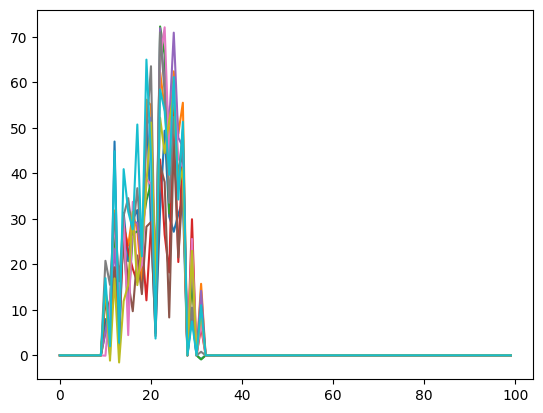

In [19]:
plt.plot(ng2['I', 0])
plt.show()

### `spikes` raster plot of input-layer

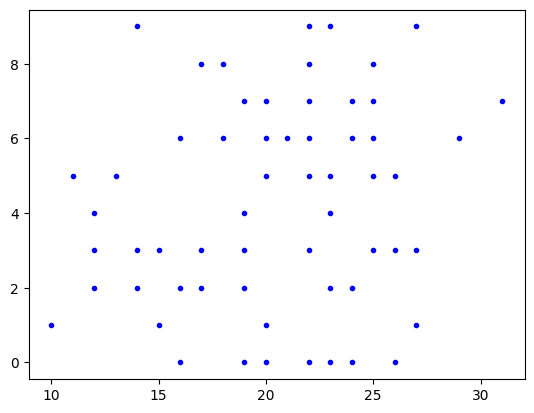

In [20]:
plt.plot(ng1['spikes.t', 0], ng1['spikes.i', 0], '.', color = "blue")

### `spikes` raster plot of output-layer

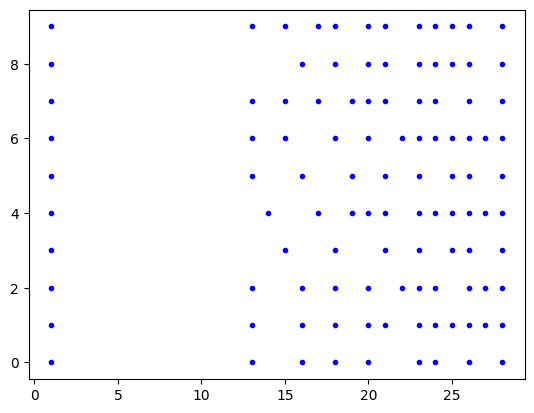

In [21]:
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue")

### `spike-trace` of input-layer

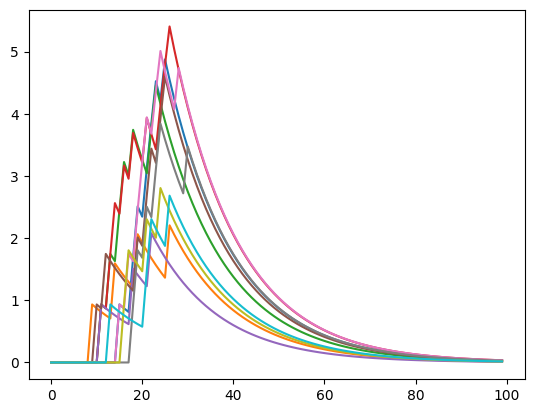

In [22]:
plt.plot(ng1['trace', 0])
plt.show()

# run multiple simulations *

### no `PoissonGenerator` at first 

In [78]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 341 : PoissionGenerator(T = 40, lamda = 20),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 5,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(6, 4)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
]) | ({
    800 : Recorder(["I"]),
}))

In [102]:
net.initialize()

for i in range(3) : 
    ng1.add_behavior(342, PoissionGenerator(T = 50, lamda = 20))
    net.simulate_iterations(50)
    ng1.remove_behavior(342)

Network['Network'](Neurons: tensor(20)|2 groups, Synapses: tensor(100)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proxim

C:\Users\Asus\AppData\Local\Temp\ipykernel_11732\1416103972.py:15: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  self.poisson = (np.exp(-self.lamda) * (self.lamda ** (ng.network.iteration - self.offset))) / (np.math.factorial(ng.network.iteration - self.offset)) / ((np.exp(-self.lamda) * (self.lamda ** self.lamda)) / (np.math.factorial(self.lamda))*2)


50xBatch: 1/1 (100%) 174.534ms
50xBatch: 1/1 (100%) 177.526ms


### input-layer spikes

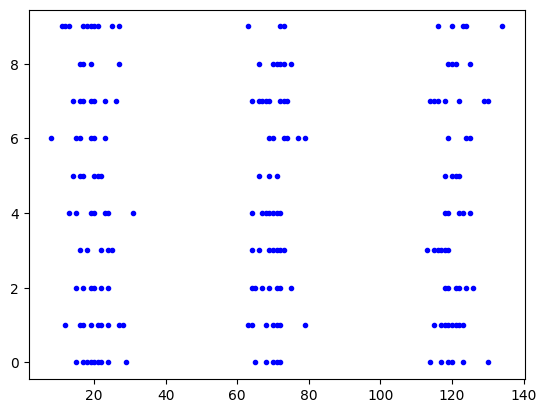

In [80]:
plt.plot(ng1['spikes.t', 0], ng1['spikes.i', 0], '.', color = "blue")

In [97]:
ng2['spikes.t'][0][10:]
ng2['spikes.i'][0][10:]

tensor([0, 2, 5, 6, 7, 8, 9, 3, 4, 0, 8, 1, 2, 5, 6, 7, 9, 0, 4, 8, 2, 6, 9, 0,
        3, 5, 7, 6, 8, 1, 2, 4, 9, 0, 5, 6, 8, 6, 8, 0, 2, 4, 5, 6, 7, 9, 1, 3,
        8, 2, 6, 0, 4, 5, 6, 7, 8, 9, 1, 2, 3, 6, 0, 4, 5, 6, 7, 8, 9, 0, 1, 2,
        3, 4, 5, 6, 8, 9, 0, 6, 7, 8, 5, 9, 6, 0, 5, 6, 8, 9, 1, 2, 4, 0, 3, 5,
        6, 7, 8, 0, 1, 2, 4, 5, 6, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 6, 8,
        2, 3, 4, 5, 6, 7, 9, 0, 5, 6, 8, 9, 0, 1, 2, 3, 4, 6, 7, 5, 8, 9, 0, 6,
        7, 2, 4, 5, 6, 8, 9])

### outputer-layer spikes

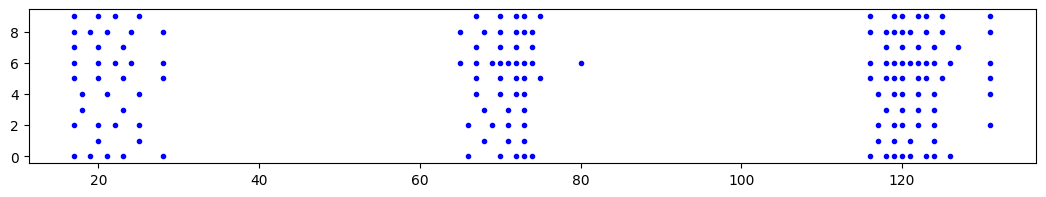

In [98]:
plt.figure(figsize = (13, 2))
plt.plot(ng2['spikes.t', 0][10:], ng2['spikes.i', 0][10:], '.', color = "blue")